# Cluster Barcelona Neighborhoods

### Import libraries

In [31]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


### Import neighborhood database with coordinates

In [2]:
import types
from botocore.client import Config
import ibm_boto3

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
body = client_335529e8571343eaa4cecdd51c945c46.get_object(Bucket='capstoneproject-donotdelete-pr-q6jyeyrogmggrb',Key='neighborhoods_coordinates_barcelona.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_coordinates = pd.read_csv(body)
df_coordinates.head()

,Neighborhood Code,Neighborhood,District Code,Disctrict,Neighborhood Latitude,Neighborhood Longitude
0,1,el Raval,1,Ciutat Vella,41.379518,2.168368
1,2,el Barri Gòtic,1,Ciutat Vella,41.383395,2.176912
2,3,la Barceloneta,1,Ciutat Vella,41.380653,2.189927
3,4,"Sant Pere, Santa Caterina i la Ribera",1,Ciutat Vella,41.372251,2.177531
4,5,el Fort Pienc,2,Eixample,41.395925,2.182325


####  Removed columns

In [5]:
new_columns = ['Neighborhood Code', 'Neighborhood Latitude', 'Neighborhood Longitude']
df_coordinates = df_coordinates.loc[:, new_columns]
df_coordinates.head()

,Neighborhood Code,Neighborhood Latitude,Neighborhood Longitude
0,1,41.379518,2.168368
1,2,41.383395,2.176912
2,3,41.380653,2.189927
3,4,41.372251,2.177531
4,5,41.395925,2.182325


### Import neighborhood's incidents database

In [6]:
def __iter__(self): return 0

body = client_335529e8571343eaa4cecdd51c945c46.get_object(Bucket='capstoneproject-donotdelete-pr-q6jyeyrogmggrb',Key='2019_incidents_gestionats_gub.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()

,Codi_Incident,Descripcio_Incident,Codi_districte,Nom_districte,Codi_barri,Nom_barri,NK_Any,Mes_any,Nom_mes,Numero_incidents_GUB
0,410,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS ...,6.0,Gràcia,31,la Vila de Gràcia,2019.0,1,Gener,85.0
1,210,ACCIDENTS DE TRÀNSIT SENSE FERITS ...,10.0,Sant Martí,73,la Verneda i la Pau,2019.0,4,Abril,4.0
2,200,INCIDÈNCIES AMB AFECTACIÓ DE VIA ...,2.0,Eixample,9,la Nova Esquerra de l'Eixample,2019.0,4,Abril,12.0
3,400,CONVIVÈNCIA VEINAL ...,6.0,Gràcia,31,la Vila de Gràcia,2019.0,4,Abril,105.0
4,670,AGRESSIONS ...,1.0,Ciutat Vella,3,la Barceloneta,2019.0,1,Gener,12.0


# Clean data

#### Select needed columns

In [7]:
df.columns

Index(['Codi_Incident', 'Descripcio_Incident', 'Codi_districte',
       'Nom_districte', 'Codi_barri', 'Nom_barri', 'NK_Any', 'Mes_any',
       'Nom_mes', 'Numero_incidents_GUB'],
      dtype='object')

In [8]:
new_columns = ['Descripcio_Incident', 'Codi_districte', 'Nom_districte', 'Codi_barri', 'Nom_barri', 'Mes_any', 'Numero_incidents_GUB']
df = df.loc[:, new_columns]
df.head()

,Descripcio_Incident,Codi_districte,Nom_districte,Codi_barri,Nom_barri,Mes_any,Numero_incidents_GUB
0,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS ...,6.0,Gràcia,31,la Vila de Gràcia,1,85.0
1,ACCIDENTS DE TRÀNSIT SENSE FERITS ...,10.0,Sant Martí,73,la Verneda i la Pau,4,4.0
2,INCIDÈNCIES AMB AFECTACIÓ DE VIA ...,2.0,Eixample,9,la Nova Esquerra de l'Eixample,4,12.0
3,CONVIVÈNCIA VEINAL ...,6.0,Gràcia,31,la Vila de Gràcia,4,105.0
4,AGRESSIONS ...,1.0,Ciutat Vella,3,la Barceloneta,1,12.0


In [ ]:
df.dtypes

#### Change columns names

In [9]:
new_columns_name_dict = {'Descripcio_Incident': 'Incident', 'Codi_barri': 'Neighborhood Code', 'Nom_barri': 'Neighborhood', 'Codi_districte': 'District Code', 'Nom_districte': 'Disctrict', 'Mes_any' : 'Month', 'Numero_incidents_GUB': 'Number of Incidents'}
df.rename(columns=new_columns_name_dict, inplace=True)
df.head()

,Incident,District Code,Disctrict,Neighborhood Code,Neighborhood,Month,Number of Incidents
0,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS ...,6.0,Gràcia,31,la Vila de Gràcia,1,85.0
1,ACCIDENTS DE TRÀNSIT SENSE FERITS ...,10.0,Sant Martí,73,la Verneda i la Pau,4,4.0
2,INCIDÈNCIES AMB AFECTACIÓ DE VIA ...,2.0,Eixample,9,la Nova Esquerra de l'Eixample,4,12.0
3,CONVIVÈNCIA VEINAL ...,6.0,Gràcia,31,la Vila de Gràcia,4,105.0
4,AGRESSIONS ...,1.0,Ciutat Vella,3,la Barceloneta,1,12.0


In [10]:
df.shape

(33856, 7)

In [11]:
df["Neighborhood"].unique()

array(['la Vila de Gràcia', 'la Verneda i la Pau',
       "la Nova Esquerra de l'Eixample", 'la Barceloneta',
       "la Dreta de l'Eixample", 'el Poble-sec', 'la Prosperitat',
       'Provençals del Poblenou', 'Sants', 'Navas', 'el Poblenou',
       'el Raval', 'Vilapicina i la Torre Llobeta', 'Baró de Viver',
       'la Vila Olímpica del Poblenou', 'Porta', 'Sants - Badal',
       'la Sagrada Família', 'Sarrià', 'Sant Antoni', 'la Marina de Port',
       'la Sagrera', 'el Coll', 'Sant Andreu', 'el Turó de la Peira',
       'Hostafrancs', 'el Putxet i el Farró', 'el Barri Gòtic',
       "el Camp de l'Arpa del Clot", 'Vallcarca i els Penitents',
       'el Clot', 'la Bordeta', "la Font d'en Fargues",
       'Sant Genís dels Agudells', 'el Congrés i els Indians',
       'les Roquetes', 'el Besòs i el Maresme', 'Verdun', 'la Guineueta',
       'les Tres Torres', 'el Carmel', 'Torre Baró', 'les Corts',
       'Sant Pere, Santa Caterina i la Ribera',
       'Sant Gervasi - la Bonanova', 'S

#### Removed NaN and Desconegut from Neighborhood Column

In [12]:
# Get names of indexes for which column Age has value 30
indexNames = df[df['Neighborhood'] == 'Desconegut'].index
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

In [13]:
df = df.dropna(subset=['Neighborhood'], axis=0).reset_index(drop=True)

In [14]:
df["Neighborhood"].unique()

array(['la Vila de Gràcia', 'la Verneda i la Pau',
       "la Nova Esquerra de l'Eixample", 'la Barceloneta',
       "la Dreta de l'Eixample", 'el Poble-sec', 'la Prosperitat',
       'Provençals del Poblenou', 'Sants', 'Navas', 'el Poblenou',
       'el Raval', 'Vilapicina i la Torre Llobeta', 'Baró de Viver',
       'la Vila Olímpica del Poblenou', 'Porta', 'Sants - Badal',
       'la Sagrada Família', 'Sarrià', 'Sant Antoni', 'la Marina de Port',
       'la Sagrera', 'el Coll', 'Sant Andreu', 'el Turó de la Peira',
       'Hostafrancs', 'el Putxet i el Farró', 'el Barri Gòtic',
       "el Camp de l'Arpa del Clot", 'Vallcarca i els Penitents',
       'el Clot', 'la Bordeta', "la Font d'en Fargues",
       'Sant Genís dels Agudells', 'el Congrés i els Indians',
       'les Roquetes', 'el Besòs i el Maresme', 'Verdun', 'la Guineueta',
       'les Tres Torres', 'el Carmel', 'Torre Baró', 'les Corts',
       'Sant Pere, Santa Caterina i la Ribera',
       'Sant Gervasi - la Bonanova', 'S

#### Change columns types

In [15]:
df = df.astype({'District Code': 'int64', 'Number of Incidents': 'int64'})
df.dtypes

Incident               object
District Code           int64
Disctrict              object
Neighborhood Code       int64
Neighborhood           object
Month                  object
Number of Incidents     int64
dtype: object

#### Add the coordinates to the existing data frame

In [16]:
# Merge both data frames so all the neighborhoods have their coordinates
df = pd.merge(df, df_coordinates, how='left', on='Neighborhood Code')
df.head()

,Incident,District Code,Disctrict,Neighborhood Code,Neighborhood,Month,Number of Incidents,Neighborhood Latitude,Neighborhood Longitude
0,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS ...,6,Gràcia,31,la Vila de Gràcia,1,85,41.403178,2.157166
1,ACCIDENTS DE TRÀNSIT SENSE FERITS ...,10,Sant Martí,73,la Verneda i la Pau,4,4,41.423220,2.202940
2,INCIDÈNCIES AMB AFECTACIÓ DE VIA ...,2,Eixample,9,la Nova Esquerra de l'Eixample,4,12,41.382816,2.149966
3,CONVIVÈNCIA VEINAL ...,6,Gràcia,31,la Vila de Gràcia,4,105,41.403178,2.157166
4,AGRESSIONS ...,1,Ciutat Vella,3,la Barceloneta,1,12,41.380653,2.189927


In [17]:
df.shape

(33163, 9)

In [18]:
df = df.dropna(subset=['Neighborhood Latitude'], axis=0).reset_index(drop=True)
df.head()

,Incident,District Code,Disctrict,Neighborhood Code,Neighborhood,Month,Number of Incidents,Neighborhood Latitude,Neighborhood Longitude
0,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS ...,6,Gràcia,31,la Vila de Gràcia,1,85,41.403178,2.157166
1,ACCIDENTS DE TRÀNSIT SENSE FERITS ...,10,Sant Martí,73,la Verneda i la Pau,4,4,41.423220,2.202940
2,INCIDÈNCIES AMB AFECTACIÓ DE VIA ...,2,Eixample,9,la Nova Esquerra de l'Eixample,4,12,41.382816,2.149966
3,CONVIVÈNCIA VEINAL ...,6,Gràcia,31,la Vila de Gràcia,4,105,41.403178,2.157166
4,AGRESSIONS ...,1,Ciutat Vella,3,la Barceloneta,1,12,41.380653,2.189927


In [19]:
df.shape

(33163, 9)

# Transform the incidents data

In [20]:
# Turning categorical variables into quantitative variables
dummy_variable = pd.get_dummies(df['Incident'])
# Concat new columns
# Merge data frame "df" and "dummy_variable" 
df_incidents = pd.concat([df, dummy_variable], axis=1)

# Drop original Incident column
df_incidents.drop('Incident', axis = 1, inplace=True)
# Removed white spaces at the end of the incidents new columns
df_incidents.columns = df_incidents.columns.str.rstrip()
df_incidents.head()

,District Code,Disctrict,Neighborhood Code,Neighborhood,Month,Number of Incidents,Neighborhood Latitude,Neighborhood Longitude,ABOCAMENT DE RESIDUS,ACCIDENTS DE TRANSIT AMB MATERIES PERILLOSSES,ACCIDENTS DE TRÀNSIT AMB FERITS,ACCIDENTS DE TRÀNSIT SENSE FERITS,ACTES CONTRA LA PROPIETAT,ACTES CONTRA LA PROPIETAT PRIVADA,ACTES CONTRA LA PROPIETAT PÚBLICA,ACTIVITAT AMB PRESOS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,AGRESSIONS,ALARMES D'INCENDI / ROBATORI,"ALTRES ACTUACIONS DE S, C,",ALTRES ACTUACIONS EN MEDI AMBIENT,ALTRES INCIDÈNCIES AMB ANIMALS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",ANIMALS / INSECTES PERILLOSOS,ANIMALS DE COMPANYIA,"ASSISTÈNCIA A CONDUCTORS EN V, P,",ASSISTÈNCIA A MALALTS MENTALS,ASSISTÈNCIA A PERSONES EN EDIFICI,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ASSISTÈNCIA EN LES PLATGES,ASSISTÈNCIA TÈCNICA,ATEMPTATS,AVARIA TÈCNICA,AVARIES DE SERVEIS MUNICIPALS,AVARIES DE SERVEIS PÚBLICS,BARALLES,CAÇA / PESCA / FLORA / FAUNA,COL·LABORACIÓ AMB ALTRES SERVEIS,COL·LBORACIÓ AMB AUTORITAT JUDICIAL / POLICIAL,COMUNICATS D'EMERGÈNCIA,CONDUCCIONS I ACOMPANYAMENTS,CONFLICTES EN LOCALS,CONTRA ELS DRETS DELS TREBALLADORS,CONTRA LA LLIBERTAT SEXUAL,CONTROLS DE TRÀNSIT,CONVIVÈNCIA VEINAL,CUSTÒDIES,DELICTES ALIMENTARIS,DELICTES CONTRA L'ORDRE PÚBLIC,Desconegut,EDIFICIS OFICIALS,ESPECTACLES EN ESPAIS PÚBLICS,ESTUPEFAENTS / PSICOTROPICS,EXPLOSIONS,FOC EXTERIOR,FOGUERES / BARBACOES,IMMOBILITZACIONS /DESIMMOBILITZACIONS,INCENDIS,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INCIDÈNCIES AMB PRESOS I DETINGUTS,INCIDÈNCIES D'ALIMENTS,INCIDÈNCIES DE LOCALS,INFRACCIONS D'ESTRANGERS,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS EN LOCALS,INFRACCIONS EN MOVIMENT,INFRACCIONS EN MOVIMENT (VEHICLES),INFRACCIONS PER ESTACIONAMENTS,INSPECCIONS / CONTROLS EN LOCALS,MANIFESTACIONS / CONCENTRACIONS,MATÈRIES PERILLOSES,MOLESTIES PER GENERADORS,NEU I GEL,OBRES / TREBALLS EN ESPAIS PÚBLICS,OCUPACIONS D'ESPAIS PÚBLICS,OCUPACIONS IL·LÍCITES,PLUJA TORRENCIAL,PROVES DEL SISTEMA,REFORMA,RESTRICCIONS TEMPORALS DE TRÀNSIT,SALVAMENTS,SENSE IDENTIFICAR,SENYALS AUTOMATITZADES,SENYALS NO AUTOMATITZADES,SINISTRES EN EDIFICIS,SISMES,SUBMINISTRAMENTS BÀSICS,SUPORTS,TRANSPORT PÚBLIC,TRASLLATS DE VEHICLES SENSE INFRACCIÓ,TRIBUS URBANES,VANDALISME,VENDA AMBULANT,VENTS FORTS,VIGILÀNCIA POLICIAL,VIOLÈNCIA DOMÈSTICA,ÀMBIT DE PROTECCIÓ DEL MENOR,ÀMBIT EDUCATIU
0,6,Gràcia,31,la Vila de Gràcia,1,85,41.403178,2.157166,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10,Sant Martí,73,la Verneda i la Pau,4,4,41.423220,2.202940,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Eixample,9,la Nova Esquerra de l'Eixample,4,12,41.382816,2.149966,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,Gràcia,31,la Vila de Gràcia,4,105,41.403178,2.157166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,Ciutat Vella,3,la Barceloneta,1,12,41.380653,2.189927,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
df_incidents_occurence = df_incidents.drop(['District Code', 'Disctrict', 'Neighborhood Code', 'Number of Incidents', 'Neighborhood Latitude', 'Neighborhood Longitude'], axis = 1)

In [22]:
incidents_grouped = df_incidents_occurence.groupby('Neighborhood').mean().reset_index()
incidents_grouped

,Neighborhood,ABOCAMENT DE RESIDUS,ACCIDENTS DE TRANSIT AMB MATERIES PERILLOSSES,ACCIDENTS DE TRÀNSIT AMB FERITS,ACCIDENTS DE TRÀNSIT SENSE FERITS,ACTES CONTRA LA PROPIETAT,ACTES CONTRA LA PROPIETAT PRIVADA,ACTES CONTRA LA PROPIETAT PÚBLICA,ACTIVITAT AMB PRESOS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,AGRESSIONS,ALARMES D'INCENDI / ROBATORI,"ALTRES ACTUACIONS DE S, C,",ALTRES ACTUACIONS EN MEDI AMBIENT,ALTRES INCIDÈNCIES AMB ANIMALS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",ANIMALS / INSECTES PERILLOSOS,ANIMALS DE COMPANYIA,"ASSISTÈNCIA A CONDUCTORS EN V, P,",ASSISTÈNCIA A MALALTS MENTALS,ASSISTÈNCIA A PERSONES EN EDIFICI,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ASSISTÈNCIA EN LES PLATGES,ASSISTÈNCIA TÈCNICA,ATEMPTATS,AVARIA TÈCNICA,AVARIES DE SERVEIS MUNICIPALS,AVARIES DE SERVEIS PÚBLICS,BARALLES,CAÇA / PESCA / FLORA / FAUNA,COL·LABORACIÓ AMB ALTRES SERVEIS,COL·LBORACIÓ AMB AUTORITAT JUDICIAL / POLICIAL,COMUNICATS D'EMERGÈNCIA,CONDUCCIONS I ACOMPANYAMENTS,CONFLICTES EN LOCALS,CONTRA ELS DRETS DELS TREBALLADORS,CONTRA LA LLIBERTAT SEXUAL,CONTROLS DE TRÀNSIT,CONVIVÈNCIA VEINAL,CUSTÒDIES,DELICTES ALIMENTARIS,DELICTES CONTRA L'ORDRE PÚBLIC,Desconegut,EDIFICIS OFICIALS,ESPECTACLES EN ESPAIS PÚBLICS,ESTUPEFAENTS / PSICOTROPICS,EXPLOSIONS,FOC EXTERIOR,FOGUERES / BARBACOES,IMMOBILITZACIONS /DESIMMOBILITZACIONS,INCENDIS,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INCIDÈNCIES AMB PRESOS I DETINGUTS,INCIDÈNCIES D'ALIMENTS,INCIDÈNCIES DE LOCALS,INFRACCIONS D'ESTRANGERS,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS EN LOCALS,INFRACCIONS EN MOVIMENT,INFRACCIONS EN MOVIMENT (VEHICLES),INFRACCIONS PER ESTACIONAMENTS,INSPECCIONS / CONTROLS EN LOCALS,MANIFESTACIONS / CONCENTRACIONS,MATÈRIES PERILLOSES,MOLESTIES PER GENERADORS,NEU I GEL,OBRES / TREBALLS EN ESPAIS PÚBLICS,OCUPACIONS D'ESPAIS PÚBLICS,OCUPACIONS IL·LÍCITES,PLUJA TORRENCIAL,PROVES DEL SISTEMA,REFORMA,RESTRICCIONS TEMPORALS DE TRÀNSIT,SALVAMENTS,SENSE IDENTIFICAR,SENYALS AUTOMATITZADES,SENYALS NO AUTOMATITZADES,SINISTRES EN EDIFICIS,SISMES,SUBMINISTRAMENTS BÀSICS,SUPORTS,TRANSPORT PÚBLIC,TRASLLATS DE VEHICLES SENSE INFRACCIÓ,TRIBUS URBANES,VANDALISME,VENDA AMBULANT,VENTS FORTS,VIGILÀNCIA POLICIAL,VIOLÈNCIA DOMÈSTICA,ÀMBIT DE PROTECCIÓ DEL MENOR,ÀMBIT EDUCATIU
0,Baró de Viver,0.000000,0.000000,0.028409,0.028409,0.000000,0.039773,0.005682,0.005682,0.056818,0.022727,0.017045,0.056818,0.000000,0.000000,0.017045,0.017045,0.022727,0.000000,0.000000,0.017045,0.039773,0.000000,0.000000,0.000000,0.000000,0.005682,0.017045,0.005682,0.000000,0.039773,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068182,0.000000,0.000000,0.005682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,0.045455,0.022727,0.017045,0.000000,0.000000,0.028409,0.000000,0.056818,0.000000,0.051136,0.000000,0.011364,0.005682,0.005682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.022727,0.005682,0.017045,0.000000,0.000000,0.028409,0.000000,0.000000,0.000000,0.022727,0.005682,0.000000,0.068182,0.022727,0.000000,0.000000
1,Can Baró,0.003021,0.000000,0.033233,0.030211,0.000000,0.030211,0.009063,0.000000,0.036254,0.027190,0.012085,0.036254,0.000000,0.003021,0.030211,0.015106,0.033233,0.012085,0.000000,0.027190,0.036254,0.000000,0.000000,0.003021,0.000000,0.021148,0.018127,0.009063,0.000000,0.027190,0.003021,0.000000,0.000000,0.003021,0.000000,0.000000,0.000000,0.036254,0.000000,0.000000,0.000000,0.000000,0.000000,0.009063,0.012085,0.000000,0.000000,0.009063,0.000000,0.033233,0.033233,0.030211,0.000000,0.000000,0.015106,0.000000,0.036254,0.003021,0.018127,0.000000,0.036254,0.003021,0.009063,0.000000,0.003021,0.000000,0.024169,0.003021,0.000000,0.000000,0.000000,0.003021,0.036254,0.000000,0.003021,0.021148,0.012085,0.006042,0.000000,0.000000,0.027190,0.012085,0.015106,0.000000,0.012085,0.015106,0.006042,0.033233,0.012085,0.012085,0.000000
2,Can Peguera,0.009050,0.000000,0.022624,0.018100,0.000000,0.031674,0.0

### Create the new dataframe and display the top 10 incidents for each neighborhood

In [23]:
# Sort the incidents in descending order
def return_most_common_incidents(row, num_top_incidents):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_incidents]

In [26]:
num_top_incidents = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top incidents
columns = ['Neighborhood']
for ind in np.arange(num_top_incidents):
    try:
        columns.append('{}{} Most Common Incidents'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Incidents'.format(ind+1))

# create a new dataframe
neighborhoods_incidents_sorted = pd.DataFrame(columns=columns)
neighborhoods_incidents_sorted['Neighborhood'] = incidents_grouped['Neighborhood']

for ind in np.arange(incidents_grouped.shape[0]):
    neighborhoods_incidents_sorted.iloc[ind, 1:] = return_most_common_incidents(incidents_grouped.iloc[ind, :], num_top_incidents)

neighborhoods_incidents_sorted.head()

,Neighborhood,1st Most Common Incidents,2nd Most Common Incidents,3rd Most Common Incidents,4th Most Common Incidents,5th Most Common Incidents,6th Most Common Incidents,7th Most Common Incidents,8th Most Common Incidents,9th Most Common Incidents,10th Most Common Incidents
0,Baró de Viver,CONVIVÈNCIA VEINAL,VIGILÀNCIA POLICIAL,"ALTRES ACTUACIONS DE S, C,",INFRACCIONS EN GUALS I RESERVES,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INFRACCIONS EN MOVIMENT,INCENDIS,COL·LABORACIÓ AMB ALTRES SERVEIS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ACTES CONTRA LA PROPIETAT PRIVADA
1,Can Baró,INFRACCIONS EN GUALS I RESERVES,RESTRICCIONS TEMPORALS DE TRÀNSIT,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INFRACCIONS PER ESTACIONAMENTS,CONVIVÈNCIA VEINAL,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,"ALTRES ACTUACIONS DE S, C,",INCIDÈNCIES AMB AFECTACIÓ DE VIA,ANIMALS DE COMPANYIA,ACCIDENTS DE TRÀNSIT AMB FERITS
2,Can Peguera,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,CONVIVÈNCIA VEINAL,"ALTRES ACTUACIONS DE S, C,",VIGILÀNCIA POLICIAL,INFRACCIONS PER ESTACIONAMENTS,ASSISTÈNCIA A PERSONES EN EDIFICI,ANIMALS DE COMPANYIA,INFRACCIONS EN GUALS I RESERVES,AGRESSIONS
3,Canyelles,INFRACCIONS EN MOVIMENT,VIGILÀNCIA POLICIAL,CONVIVÈNCIA VEINAL,"ALTRES ACTUACIONS DE S, C,",ACCIDENTS DE TRÀNSIT SENSE FERITS,ACTES CONTRA LA PROPIETAT PRIVADA,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS PER ESTACIONAMENTS,ACCIDENTS DE TRÀNSIT AMB FERITS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS
4,Ciutat Meridiana,"ALTRES ACTUACIONS DE S, C,",INFRACCIONS EN GUALS I RESERVES,VIOLÈNCIA DOMÈSTICA,VIGILÀNCIA POLICIAL,INFRACCIONS PER ESTACIONAMENTS,ASSISTÈNCIA A PERSONES EN EDIFICI,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,CONVIVÈNCIA VEINAL,INFRACCIONS EN MOVIMENT,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA"


# Cluster Barcelona Neighborhoods

In [27]:
incidents_grouped_clustering = incidents_grouped.drop('Neighborhood', 1)

### The Elbow Method

In [28]:
from scipy.spatial import distance

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_points = points.loc[i]
            curr_sse = distance.euclidean(curr_points, curr_center)

        sse.append(curr_sse)

    return sse

In [29]:
sse = calculate_WSS(incidents_grouped_clustering, 10)

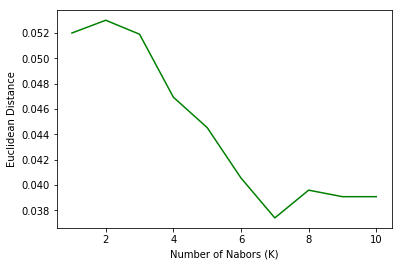

In [32]:
plt.plot(range(1, 11), sse,'g')
plt.ylabel('Euclidean Distance')
plt.xlabel('Number of Nabors (K)')
plt.show()

### The Silhouette Method

In [33]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(incidents_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(incidents_grouped_clustering, labels, metric = 'euclidean'))

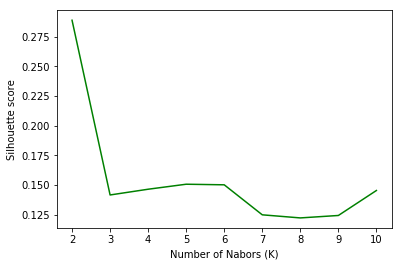

In [34]:
plt.plot(range(2, kmax+1), sil,'g')
plt.ylabel('Silhouette score')
plt.xlabel('Number of Nabors (K)')
plt.show()

### Calculate the clusters for K=7

In [35]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(incidents_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 5, 6, 5, 5, 1, 1, 1, 3, 1], dtype=int32)

In [36]:
# add clustering labels
neighborhoods_incidents_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neigborhoods_merged = df
neigborhoods_merged.drop(['District Code', 'Neighborhood Code', 'Incident', 'Month', 'Number of Incidents'], axis=1, inplace=True)

# merge barcelona_grouped with barcelona_data to add latitude/longitude for each neighborhood
neigborhoods_merged = neigborhoods_merged.join(neighborhoods_incidents_sorted.set_index('Neighborhood'), on='Neighborhood')
neigborhoods_merged.dropna(subset=['Cluster Labels'], axis=0, inplace=True)

neigborhoods_merged = neigborhoods_merged.drop_duplicates().reset_index(drop=True) # drop duplicates

neigborhoods_merged.head()# add clustering labels

,Disctrict,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Incidents,2nd Most Common Incidents,3rd Most Common Incidents,4th Most Common Incidents,5th Most Common Incidents,6th Most Common Incidents,7th Most Common Incidents,8th Most Common Incidents,9th Most Common Incidents,10th Most Common Incidents
0,Gràcia,la Vila de Gràcia,41.403178,2.157166,2,INFRACCIONS EN GUALS I RESERVES,MANIFESTACIONS / CONCENTRACIONS,INFRACCIONS PER ESTACIONAMENTS,INFRACCIONS EN MOVIMENT,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INCIDÈNCIES DE LOCALS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,AGRESSIONS,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INCIDÈNCIES AMB AFECTACIÓ DE VIA
1,Sant Martí,la Verneda i la Pau,41.423220,2.202940,1,ALARMES D'INCENDI / ROBATORI,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN EDIFICI,INCIDÈNCIES DE LOCALS,INFRACCIONS EN GUALS I RESERVES,INCENDIS,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS,ANIMALS DE COMPANYIA,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA"
2,Eixample,la Nova Esquerra de l'Eixample,41.382816,2.149966,2,INFRACCIONS EN MOVIMENT,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INFRACCIONS EN GUALS I RESERVES,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCENDIS,INFRACCIONS PER ESTACIONAMENTS,MANIFESTACIONS / CONCENTRACIONS,ANIMALS DE COMPANYIA,"ASSISTÈNCIA A CONDUCTORS EN V, P,"
3,Ciutat Vella,la Barceloneta,41.380653,2.189927,2,AVARIES DE SERVEIS MUNICIPALS,COL·LABORACIÓ AMB ALTRES SERVEIS,INFRACCIONS EN GUALS I RESERVES,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",CONFLICTES EN LOCALS,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,"ALTRES ACTUACIONS DE S, C,"
4,Eixample,la Dreta de l'Eixample,41.394124,2.166471,2,INFRACCIONS EN GUALS I RESERVES,"ALTRES ACTUACIONS DE S, C,",OCUPACIONS D'ESPAIS PÚBLICS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,CONVIVÈNCIA VEINAL,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",MANIFESTACIONS / CONCENTRACIONS,INSPECCIONS / CONTROLS EN LOCALS,INFRACCIONS PER ESTACIONAMENTS,INFRACCIONS EN MOVIMENT (VEHICLES)


# Visualize the clusters

### Cluster 0

In [37]:
neigborhoods_merged.loc[neigborhoods_merged['Cluster Labels'] == 0, neigborhoods_merged.columns[[1] + list(range(5, neigborhoods_merged.shape[1]))]]

,Neighborhood,1st Most Common Incidents,2nd Most Common Incidents,3rd Most Common Incidents,4th Most Common Incidents,5th Most Common Incidents,6th Most Common Incidents,7th Most Common Incidents,8th Most Common Incidents,9th Most Common Incidents,10th Most Common Incidents
18,Sarrià,COL·LABORACIÓ AMB ALTRES SERVEIS,SENYALS AUTOMATITZADES,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",INCIDÈNCIES DE LOCALS,INFRACCIONS EN GUALS I RESERVES,ANIMALS DE COMPANYIA,INFRACCIONS EN MOVIMENT,"ASSISTÈNCIA A CONDUCTORS EN V, P,",INFRACCIONS PER ESTACIONAMENTS,"ALTRES ACTUACIONS DE S, C,"
29,Vallcarca i els Penitents,"ALTRES ACTUACIONS DE S, C,",ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INFRACCIONS EN MOVIMENT,ASSISTÈNCIA A PERSONES EN EDIFICI,ALARMES D'INCENDI / ROBATORI,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,RESTRICCIONS TEMPORALS DE TRÀNSIT,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,COL·LABORACIÓ AMB ALTRES SERVEIS
39,les Tres Torres,INFRACCIONS EN MOVIMENT,ACTES CONTRA LA PROPIETAT PRIVADA,INCENDIS,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INFRACCIONS EN GUALS I RESERVES,CONVIVÈNCIA VEINAL,INFRACCIONS PER ESTACIONAMENTS
44,Sant Gervasi - la Bonanova,"ALTRES ACTUACIONS DE S, C,",COL·LABORACIÓ AMB ALTRES SERVEIS,ASSISTÈNCIA A PERSONES EN EDIFICI,INCENDIS,INCIDÈNCIES DE LOCALS,INFRACCIONS EN GUALS I RESERVES,ANIMALS DE COMPANYIA,INFRACCIONS EN MOVIMENT,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INFRACCIONS PER ESTACIONAMENTS
60,la Salut,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",ACTES CONTRA LA PROPIETAT PRIVADA,COL·LABORACIÓ AMB ALTRES SERVEIS,CONVIVÈNCIA VEINAL,INFRACCIONS PER ESTACIONAMENTS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INFRACCIONS EN MOVIMENT,INFRACCIONS EN GUALS I RESERVES,"ALTRES ACTUACIONS DE S, C,",ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS
63,Pedralbes,COL·LABORACIÓ AMB ALTRES SERVEIS,ACTES CONTRA LA PROPIETAT PRIVADA,"ALTRES ACTUACIONS DE S, C,",INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,SENYALS AUTOMATITZADES,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",CONVIVÈNCIA VEINAL,SUPORTS
64,"Vallvidrera, el Tibidabo i les Planes",ANIMALS DE COMPANYIA,INFRACCIONS EN GUALS I RESERVES,VIGILÀNCIA POLICIAL,"ALTRES ACTUACIONS DE S, C,",INCIDÈNCIES AMB AFECTACIÓ DE VIA,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ACCIDENTS DE TRÀNSIT AMB FERITS,INFRACCIONS PER ESTACIONAMENTS,CONVIVÈNCIA VEINAL,ACCIDENTS DE TRÀNSIT SENSE FERITS
67,la Marina del Prat Vermell,"ALTRES ACTUACIONS DE S, C,",ACCIDENTS DE TRÀNSIT SENSE FERITS,INFRACCIONS EN MOVIMENT,ACTIVITAT AMB PRESOS,CONDUCCIONS I ACOMPANYAMENTS,INFRACCIONS EN GUALS I RESERVES,SENYALS AUTOMATITZADES,COL·LABORACIÓ AMB ALTRES SERVEIS,CONTROLS DE TRÀNSIT,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS


### Cluster 1

In [38]:
neigborhoods_merged.loc[neigborhoods_merged['Cluster Labels'] == 1, neigborhoods_merged.columns[[1] + list(range(5, neigborhoods_merged.shape[1]))]]

,Neighborhood,1st Most Common Incidents,2nd Most Common Incidents,3rd Most Common Incidents,4th Most Common Incidents,5th Most Common Incidents,6th Most Common Incidents,7th Most Common Incidents,8th Most Common Incidents,9th Most Common Incidents,10th Most Common Incidents
1,la Verneda i la Pau,ALARMES D'INCENDI / ROBATORI,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN EDIFICI,INCIDÈNCIES DE LOCALS,INFRACCIONS EN GUALS I RESERVES,INCENDIS,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS,ANIMALS DE COMPANYIA,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA"
6,la Prosperitat,INCENDIS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN EDIFICI,CONVIVÈNCIA VEINAL,COL·LABORACIÓ AMB ALTRES SERVEIS,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA","ALTRES ACTUACIONS DE S, C,",INFRACCIONS EN GUALS I RESERVES,INCIDÈNCIES DE LOCALS
7,Provençals del Poblenou,INFRACCIONS PER ESTACIONAMENTS,ACCIDENTS DE TRÀNSIT SENSE FERITS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,"ALTRES ACTUACIONS DE S, C,",ACTES CONTRA LA PROPIETAT PRIVADA,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",SENYALS AUTOMATITZADES,COL·LABORACIÓ AMB ALTRES SERVEIS,INCENDIS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS
9,Navas,INCENDIS,INCIDÈNCIES DE LOCALS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",CONVIVÈNCIA VEINAL,AGRESSIONS,COL·LABORACIÓ AMB ALTRES SERVEIS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN EDIFICI,INFRACCIONS PER ESTACIONAMENTS,ACTES CONTRA LA PROPIETAT PRIVADA
12,Vilapicina i la Torre Llobeta,INCENDIS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INFRACCIONS PER ESTACIONAMENTS,INFRACCIONS EN MOVIMENT,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",INFRACCIONS EN GUALS I RESERVES,"ALTRES ACTUACIONS DE S, C,",ALARMES D'INCENDI / ROBATORI,INCIDÈNCIES DE LOCALS
15,Porta,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INCIDÈNCIES DE LOCALS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INFRACCIONS EN GUALS I RESERVES,ASSISTÈNCIA A PERSONES EN EDIFICI,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS,COL·LABORACIÓ AMB ALTRES SERVEIS,"ALTRES ACTUACIONS DE S, C,"
16,Sants - Badal,"ALTRES ACTUACIONS DE S, C,",COL·LABORACIÓ AMB ALTRES SERVEIS,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",AGRESSIONS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,CONVIVÈNCIA VEINAL,ASSISTÈNCIA A PERSONES EN EDIFICI
20,la Marina de Port,CONVIVÈNCIA VEINAL,SENYALS AUTOMATITZADES,INCENDIS,INCIDÈNCIES AMB AFECTACIÓ DE VIA,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN EDIFICI,INCIDÈNCIES DE LOCALS,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS
21,la Sagrera,INFRACCIONS EN GUALS I RESERVES,ACTES CONTRA LA PROPIETAT PRIVADA,COL·LABORACIÓ AMB ALTRES SERVEIS,ANIMALS DE COMPANYIA,CONVIVÈNCIA VEINAL,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA","ALTRES ACTUACIONS DE S, C,",ALARMES D'INCENDI / ROBATORI,INCENDIS,INCIDÈNCIES AMB AFECTACIÓ DE VIA
25,Hostafrancs,INFRACCIONS PER ESTACIONAMENTS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,BARALLES,CONVIVÈNCIA VEINAL,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN EDIFICI,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INCIDÈNCIES DE LOCALS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA"


### Cluster 2

In [39]:
neigborhoods_merged.loc[neigborhoods_merged['Cluster Labels'] == 2, neigborhoods_merged.columns[[1] + list(range(5, neigborhoods_merged.shape[1]))]]

,Neighborhood,1st Most Common Incidents,2nd Most Common Incidents,3rd Most Common Incidents,4th Most Common Incidents,5th Most Common Incidents,6th Most Common Incidents,7th Most Common Incidents,8th Most Common Incidents,9th Most Common Incidents,10th Most Common Incidents
0,la Vila de Gràcia,INFRACCIONS EN GUALS I RESERVES,MANIFESTACIONS / CONCENTRACIONS,INFRACCIONS PER ESTACIONAMENTS,INFRACCIONS EN MOVIMENT,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INCIDÈNCIES DE LOCALS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,AGRESSIONS,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INCIDÈNCIES AMB AFECTACIÓ DE VIA
2,la Nova Esquerra de l'Eixample,INFRACCIONS EN MOVIMENT,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INFRACCIONS EN GUALS I RESERVES,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCENDIS,INFRACCIONS PER ESTACIONAMENTS,MANIFESTACIONS / CONCENTRACIONS,ANIMALS DE COMPANYIA,"ASSISTÈNCIA A CONDUCTORS EN V, P,"
3,la Barceloneta,AVARIES DE SERVEIS MUNICIPALS,COL·LABORACIÓ AMB ALTRES SERVEIS,INFRACCIONS EN GUALS I RESERVES,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",CONFLICTES EN LOCALS,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,"ALTRES ACTUACIONS DE S, C,"
4,la Dreta de l'Eixample,INFRACCIONS EN GUALS I RESERVES,"ALTRES ACTUACIONS DE S, C,",OCUPACIONS D'ESPAIS PÚBLICS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,CONVIVÈNCIA VEINAL,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",MANIFESTACIONS / CONCENTRACIONS,INSPECCIONS / CONTROLS EN LOCALS,INFRACCIONS PER ESTACIONAMENTS,INFRACCIONS EN MOVIMENT (VEHICLES)
5,el Poble-sec,INCIDÈNCIES DE LOCALS,ESPECTACLES EN ESPAIS PÚBLICS,INFRACCIONS EN GUALS I RESERVES,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,AGRESSIONS,ALARMES D'INCENDI / ROBATORI,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCENDIS,"ALTRES ACTUACIONS DE S, C,"
8,Sants,MANIFESTACIONS / CONCENTRACIONS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INCIDÈNCIES DE LOCALS,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCENDIS,ASSISTÈNCIA A PERSONES EN EDIFICI,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS
10,el Poblenou,COL·LABORACIÓ AMB ALTRES SERVEIS,SENYALS AUTOMATITZADES,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",INCIDÈNCIES DE LOCALS,ANIMALS DE COMPANYIA,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS,ASSISTÈNCIA A PERSONES EN EDIFICI
11,el Raval,INFRACCIONS PER ESTACIONAMENTS,INCENDIS,MANIFESTACIONS / CONCENTRACIONS,INSPECCIONS / CONTROLS EN LOCALS,COL·LABORACIÓ AMB ALTRES SERVEIS,INFRACCIONS EN MOVIMENT,INFRACCIONS EN GUALS I RESERVES,INCIDÈNCIES DE LOCALS,ANIMALS / INSECTES PERILLOSOS,ANIMALS DE COMPANYIA
14,la Vila Olímpica del Poblenou,COL·LABORACIÓ AMB ALTRES SERVEIS,AVARIES DE SERVEIS PÚBLICS,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS EN MOVIMENT,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INFRACCIONS PER ESTACIONAMENTS,ANIMALS DE COMPANYIA,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",CONVIVÈNCIA VEINAL,AGRESSIONS
17,la Sagrada Família,AGRESSIONS,INFRACCIONS PER ESTACIONAMENTS,"ALTRES ACTUACIONS DE S, C,",ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN EDIFICI,"ASSISTÈNCIA A CONDUCTORS EN V, P,",ESTUPEFAENTS / PSICOTROPICS,MANIFESTACIONS / CONCENTRACIONS,INSPECCIONS / CONTROLS EN LOCALS,BARALLES


### Cluster 3

In [40]:
neigborhoods_merged.loc[neigborhoods_merged['Cluster Labels'] == 3, neigborhoods_merged.columns[[1] + list(range(5, neigborhoods_merged.shape[1]))]]

,Neighborhood,1st Most Common Incidents,2nd Most Common Incidents,3rd Most Common Incidents,4th Most Common Incidents,5th Most Common Incidents,6th Most Common Incidents,7th Most Common Incidents,8th Most Common Incidents,9th Most Common Incidents,10th Most Common Incidents
22,el Coll,ANIMALS DE COMPANYIA,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INFRACCIONS PER ESTACIONAMENTS,CONVIVÈNCIA VEINAL,INFRACCIONS EN GUALS I RESERVES,ACCIDENTS DE TRÀNSIT AMB FERITS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,"ALTRES ACTUACIONS DE S, C,",ACCIDENTS DE TRÀNSIT SENSE FERITS,ACTES CONTRA LA PROPIETAT PRIVADA
32,la Font d'en Fargues,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",INFRACCIONS PER ESTACIONAMENTS,"ALTRES ACTUACIONS DE S, C,",CONVIVÈNCIA VEINAL,INFRACCIONS EN MOVIMENT,INFRACCIONS EN GUALS I RESERVES,ACTES CONTRA LA PROPIETAT PRIVADA
33,Sant Genís dels Agudells,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INFRACCIONS EN GUALS I RESERVES,CONVIVÈNCIA VEINAL,VIGILÀNCIA POLICIAL,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,"ALTRES ACTUACIONS DE S, C,",INFRACCIONS PER ESTACIONAMENTS,INFRACCIONS EN MOVIMENT,ACTES CONTRA LA PROPIETAT PRIVADA,ANIMALS DE COMPANYIA
41,Torre Baró,INFRACCIONS EN MOVIMENT,CONVIVÈNCIA VEINAL,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,"ALTRES ACTUACIONS DE S, C,",VIGILÀNCIA POLICIAL,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INCIDÈNCIES AMB PERILL PEL TRÀNSIT,INCENDIS,INCIDÈNCIES AMB AFECTACIÓ DE VIA,SUPORTS
57,la Vall d'Hebron,INFRACCIONS PER ESTACIONAMENTS,INFRACCIONS EN MOVIMENT,VIGILÀNCIA POLICIAL,COL·LABORACIÓ AMB ALTRES SERVEIS,"ALTRES ACTUACIONS DE S, C,",ACCIDENTS DE TRÀNSIT AMB FERITS,ACCIDENTS DE TRÀNSIT SENSE FERITS,SUPORTS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS
72,Montbau,ACCIDENTS DE TRÀNSIT SENSE FERITS,INFRACCIONS EN MOVIMENT,VIGILÀNCIA POLICIAL,INFRACCIONS PER ESTACIONAMENTS,CONVIVÈNCIA VEINAL,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INCIDÈNCIES AMB AFECTACIÓ DE VIA,ACCIDENTS DE TRÀNSIT AMB FERITS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA"


### Cluster 4

In [41]:
neigborhoods_merged.loc[neigborhoods_merged['Cluster Labels'] == 4, neigborhoods_merged.columns[[1] + list(range(5, neigborhoods_merged.shape[1]))]]

,Neighborhood,1st Most Common Incidents,2nd Most Common Incidents,3rd Most Common Incidents,4th Most Common Incidents,5th Most Common Incidents,6th Most Common Incidents,7th Most Common Incidents,8th Most Common Incidents,9th Most Common Incidents,10th Most Common Incidents
13,Baró de Viver,CONVIVÈNCIA VEINAL,VIGILÀNCIA POLICIAL,"ALTRES ACTUACIONS DE S, C,",INFRACCIONS EN GUALS I RESERVES,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INFRACCIONS EN MOVIMENT,INCENDIS,COL·LABORACIÓ AMB ALTRES SERVEIS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ACTES CONTRA LA PROPIETAT PRIVADA
62,Vallbona,VIGILÀNCIA POLICIAL,INFRACCIONS EN MOVIMENT,CONVIVÈNCIA VEINAL,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INCENDIS,ACCIDENTS DE TRÀNSIT AMB FERITS,"ALTRES ACTUACIONS DE S, C,",ALARMES D'INCENDI / ROBATORI,SUPORTS,ACTES CONTRA LA PROPIETAT PRIVADA


### Cluster 5

In [42]:
neigborhoods_merged.loc[neigborhoods_merged['Cluster Labels'] == 5, neigborhoods_merged.columns[[1] + list(range(5, neigborhoods_merged.shape[1]))]]

,Neighborhood,1st Most Common Incidents,2nd Most Common Incidents,3rd Most Common Incidents,4th Most Common Incidents,5th Most Common Incidents,6th Most Common Incidents,7th Most Common Incidents,8th Most Common Incidents,9th Most Common Incidents,10th Most Common Incidents
24,el Turó de la Peira,"ALTRES ACTUACIONS DE S, C,",ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,INCENDIS,INCIDÈNCIES DE LOCALS,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS EN MOVIMENT,INFRACCIONS PER ESTACIONAMENTS,ANIMALS DE COMPANYIA,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN EDIFICI
35,les Roquetes,CONVIVÈNCIA VEINAL,ACCIDENTS DE TRÀNSIT AMB FERITS,INFRACCIONS EN MOVIMENT,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INFRACCIONS EN GUALS I RESERVES,"ALTRES ACTUACIONS DE S, C,",INCIDÈNCIES AMB AFECTACIÓ DE VIA,ACTES CONTRA LA PROPIETAT PRIVADA,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",INFRACCIONS PER ESTACIONAMENTS
37,Verdun,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,SUPORTS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,"ALTRES ACTUACIONS DE S, C,",INFRACCIONS PER ESTACIONAMENTS,INFRACCIONS EN MOVIMENT,INFRACCIONS EN GUALS I RESERVES,CONVIVÈNCIA VEINAL,ASSISTÈNCIA A PERSONES EN EDIFICI,INCIDÈNCIES DE LOCALS
49,la Font de la Guatlla,ACCIDENTS DE TRÀNSIT SENSE FERITS,ACCIDENTS DE TRÀNSIT AMB FERITS,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",INFRACCIONS EN MOVIMENT,INFRACCIONS EN GUALS I RESERVES,ACTES CONTRA LA PROPIETAT PRIVADA,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,"ALTRES ACTUACIONS DE S, C,",ASSISTÈNCIA A PERSONES EN EDIFICI,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS
52,la Teixonera,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS PER ESTACIONAMENTS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ACCIDENTS DE TRÀNSIT SENSE FERITS,CONVIVÈNCIA VEINAL,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ACTES CONTRA LA PROPIETAT PRIVADA,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA",INFRACCIONS EN MOVIMENT,"ALTRES ACTUACIONS DE S, C,"
56,Ciutat Meridiana,"ALTRES ACTUACIONS DE S, C,",INFRACCIONS EN GUALS I RESERVES,VIOLÈNCIA DOMÈSTICA,VIGILÀNCIA POLICIAL,INFRACCIONS PER ESTACIONAMENTS,ASSISTÈNCIA A PERSONES EN EDIFICI,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,CONVIVÈNCIA VEINAL,INFRACCIONS EN MOVIMENT,"ALTRES INTERVENCIONS DE P, ADMINISTRATIVA"
66,Canyelles,INFRACCIONS EN MOVIMENT,VIGILÀNCIA POLICIAL,CONVIVÈNCIA VEINAL,"ALTRES ACTUACIONS DE S, C,",ACCIDENTS DE TRÀNSIT SENSE FERITS,ACTES CONTRA LA PROPIETAT PRIVADA,INFRACCIONS EN GUALS I RESERVES,INFRACCIONS PER ESTACIONAMENTS,ACCIDENTS DE TRÀNSIT AMB FERITS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS
68,la Trinitat Vella,INFRACCIONS EN MOVIMENT,ACCIDENTS DE TRÀNSIT SENSE FERITS,"ALTRES ACTUACIONS DE S, C,",ANIMALS DE COMPANYIA,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INCIDÈNCIES AMB AFECTACIÓ DE VIA,INCENDIS,INFRACCIONS PER ESTACIONAMENTS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,CONVIVÈNCIA VEINAL
69,Can Baró,INFRACCIONS EN GUALS I RESERVES,RESTRICCIONS TEMPORALS DE TRÀNSIT,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,INFRACCIONS PER ESTACIONAMENTS,CONVIVÈNCIA VEINAL,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,"ALTRES ACTUACIONS DE S, C,",INCIDÈNCIES AMB AFECTACIÓ DE VIA,ANIMALS DE COMPANYIA,ACCIDENTS DE TRÀNSIT AMB FERITS
71,la Trinitat Nova,"ALTRES ACTUACIONS DE S, C,",VIOLÈNCIA DOMÈSTICA,VIGILÀNCIA POLICIAL,ACCIDENTS DE TRÀNSIT AMB FERITS,INFRACCIONS EN GUALS I RESERVES,TRASLLATS DE VEHICLES SENSE INFRACCIÓ,INFRACCIONS EN MOVIMENT,SUPORTS,INFRACCIONS PER ESTACIONAMENTS,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS


### Cluster 6

In [43]:
neigborhoods_merged.loc[neigborhoods_merged['Cluster Labels'] == 6, neigborhoods_merged.columns[[1] + list(range(5, neigborhoods_merged.shape[1]))]]

,Neighborhood,1st Most Common Incidents,2nd Most Common Incidents,3rd Most Common Incidents,4th Most Common Incidents,5th Most Common Incidents,6th Most Common Incidents,7th Most Common Incidents,8th Most Common Incidents,9th Most Common Incidents,10th Most Common Incidents
59,Can Peguera,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,CONVIVÈNCIA VEINAL,"ALTRES ACTUACIONS DE S, C,",VIGILÀNCIA POLICIAL,INFRACCIONS PER ESTACIONAMENTS,ASSISTÈNCIA A PERSONES EN EDIFICI,ANIMALS DE COMPANYIA,INFRACCIONS EN GUALS I RESERVES,AGRESSIONS
70,la Clota,ASSISTÈNCIA A PERSONES EN ESPAIS PÚBLICS,ACCIDENTS DE TRÀNSIT AMB FERITS,INFRACCIONS EN MOVIMENT,ACTES CONTRA LA PROPIETAT PRIVADA,"ALTRES ACTUACIONS DE S, C,",INFRACCIONS PER ESTACIONAMENTS,CONVIVÈNCIA VEINAL,ACTIVITATS MOLESTES EN ESPAIS PÚBLICS,ANIMALS DE COMPANYIA,ABOCAMENT DE RESIDUS


# Visualize the clusters in Barcelona's map

In [44]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done

# All requested packages already installed.



In [45]:
!conda install -c conda-forge geocoder

Solving environment: done

# All requested packages already installed.



In [47]:
import folium
import geocoder

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode('Barcelona')
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neigborhoods_merged['Neighborhood Latitude'], neigborhoods_merged['Neighborhood Longitude'], neigborhoods_merged['Neighborhood'], neigborhoods_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters